In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression, LassoCV

In [4]:
df = pd.read_csv('cleaned_data.csv', index_col = False);
df_sub = pd.read_csv('cleaned_data_submittal.csv', index_col = False)

id_ = df.Id
sub_id = df_sub.Id

df.drop('Id', inplace = True, axis = 1)
df_sub.drop('Id', inplace = True, axis = 1)

df.drop('Unnamed: 0', axis = 1, inplace = True)
df_sub.drop('Unnamed: 0', axis = 1, inplace = True)

df["Bsmt1stFlrSqFt"] = df['TotalBsmtSF'] + df['1stFlrSF']
df.drop(['TotalBsmtSF', '1stFlrSF'], axis = 1, inplace = True)

df_sub["Bsmt1stFlrSqFt"] = df_sub['TotalBsmtSF'] + df_sub['1stFlrSF']
df_sub.drop(['TotalBsmtSF', '1stFlrSF'], axis = 1, inplace = True)

df.YrsOld = df.YrsOld.apply(np.sqrt)
df_sub.YrsOld = df.YrsOld.apply(np.sqrt)

In [3]:
corr_ = df.corr()

In [ ]:
abs(corr_['SalePrice']).nlargest(20)[1:14]

In [6]:
cols_to_use = ['OverallQual', 'GrLivArea', 'KitchenQual', 'GarageCars', 'GarageArea', 'ExterQual_TA',
               'NoBath', 'BsmtQual', 'TotRmsAbvGrd', 'YrsOld', 'YrsSinceRemod', 'Bsmt1stFlrSqFt']

In [7]:
y = df.SalePrice;
x = df[cols_to_use]
x_1 = df_sub[cols_to_use]
df.drop('SalePrice', axis = 1, inplace = True)

### Linear Reg

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [7]:
LR = LinearRegression().fit(X_train, y_train)
y_pred = LR.predict(X_test)

In [8]:
y_test.shape

(438,)

In [ ]:
plt.scatter(y_pred, y_test)
plt.title('Predicted vs Actual (Linear Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y_pred_sub = np.round(np.exp(y_pred_sub),2)

In [9]:
from sklearn.metrics import mean_squared_log_error
#print(f"The mean squared error when training on the MI selected features is {mean_squared_log_error(y_train, miEst.predict(mi_X_train))}.")
print(f"When testing on the test data, the RMSE is {mean_squared_error(np.log(y_test), np.log(y_pred), squared=False)}")



When testing on the test data, the RMSE is 0.1563912072264268


In [10]:
LR.score(X_test, y_test)

0.7849443349239302

In [11]:
from sklearn.metrics import r2_score
R2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test.shape[1]
Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)
Adj_r2

0.733769615755687

In [12]:
R2

0.7849443349239302

In [ ]:
y_pred_sub = pd.DataFrame(y_pred_sub, index =  sub_id, columns = ['SalePrice']);
y_pred_sub

In [ ]:
y_pred_sub.to_csv('Nlyford_sub_LR.csv' )

## XG

In [1]:
# Set the model
from xgboost import XGBRegressor

/Users/noahlyford/opt/anaconda3/envs/PythonEnvironment/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
xgb = XGBRegressor(n_estimators=1500, learning_rate=0.01, loss = 'absolute_error', max_features = 'sqrt')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [13]:
xgb.fit(X_train, y_train)

[15:27:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "loss", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01,
             loss='absolute_error', max_delta_step=0, max_depth=6,
             max_features='sqrt', min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [24]:
predictions = xgb.predict(X_test)
predictions_ = xgb.predict(df_sub)

In [17]:
#predictions

In [18]:
xgb.score(X_test, y_test)

0.833443130265102

In [20]:
mean_squared_error(np.log(y_test), np.log(predictions), squared = False)

0.13058934533007116

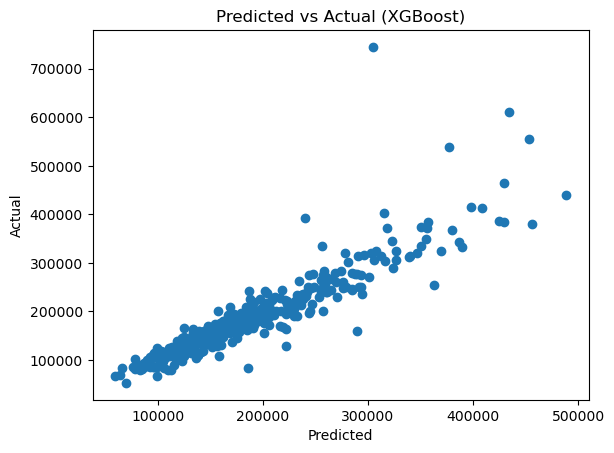

In [23]:
plt.scatter(predictions, y_test)
plt.title('Predicted vs Actual (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
from sklearn.metrics import r2_score
R2 = r2_score(y_test, predictions)
n = len(y_test)
p = X_test.shape[1]
Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)
Adj_r2

0.7938092009230866

In [ ]:
predictions = np.exp(predictions).round(2)

In [29]:
predictions_

array([130917.19, 164919.62, 188991.83, ..., 174023.61, 108978.22,
       219603.05], dtype=float32)

In [27]:
y_pred_sub_xg = pd.DataFrame(predictions_, index =  sub_id, columns = ['SalePrice'])

In [28]:
y_pred_sub_xg

,SalePrice
Id,
1461,130917.187500
1462,164919.625000
1463,188991.828125
1464,190280.921875
1465,196566.703125
...,...
2915,82170.593750
2916,88302.617188
2917,174023.609375


In [30]:
y_pred_sub_xg.to_csv('Nlyford_sub_xg.csv' )

## NN

In [31]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt

In [32]:
NN_model = Sequential()

2022-11-27 15:46:51.002970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
#Input
NN_model.add(Dense(128, input_dim = df.shape[1], activation = 'relu'))

#Hidden
NN_model.add(Dense(256, input_dim = df.shape[1], activation = 'relu')),
Dropout(.2),
NN_model.add(Dense(256, input_dim = df.shape[1], activation = 'relu')),
Dropout(.2),
NN_model.add(Dense(256, input_dim = df.shape[1], activation = 'relu'))
#Output
NN_model.add(Dense(1, input_dim = df.shape[1], activation = 'linear'))

NN_model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_squared_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               10880     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 175,745
Trainable params: 175,745
Non-trainable params: 0
_________________________________________________________________


In [34]:
NN_model.fit(X_train, y_train, epochs = 1000, batch_size = 32, validation_split = .2)

Epoch 1/1000
26/26 [==============================] - 0s 5ms/step - loss: 25919723520.0000 - mean_squared_error: 25919723520.0000 - val_loss: 50810490880.0000 - val_mean_squared_error: 50810490880.0000
Epoch 2/1000
26/26 [==============================] - 0s 2ms/step - loss: 24448950272.0000 - mean_squared_error: 24448950272.0000 - val_loss: 12585823232.0000 - val_mean_squared_error: 12585823232.0000
Epoch 3/1000
26/26 [==============================] - 0s 2ms/step - loss: 8314183680.0000 - mean_squared_error: 8314183680.0000 - val_loss: 8479934464.0000 - val_mean_squared_error: 8479934464.0000
Epoch 4/1000
26/26 [==============================] - 0s 2ms/step - loss: 5321513472.0000 - mean_squared_error: 5321513472.0000 - val_loss: 5100774912.0000 - val_mean_squared_error: 5100774912.0000
Epoch 5/1000
26/26 [==============================] - 0s 2ms/step - loss: 3970909440.0000 - mean_squared_error: 3970909440.0000 - val_loss: 3379359488.0000 - val_mean_squared_error: 3379359488.0000
Ep

Epoch 84/1000
26/26 [==============================] - 0s 2ms/step - loss: 1425912448.0000 - mean_squared_error: 1425912448.0000 - val_loss: 666164864.0000 - val_mean_squared_error: 666164864.0000
Epoch 85/1000
26/26 [==============================] - 0s 2ms/step - loss: 1399726976.0000 - mean_squared_error: 1399726976.0000 - val_loss: 1032612544.0000 - val_mean_squared_error: 1032612544.0000
Epoch 86/1000
26/26 [==============================] - 0s 2ms/step - loss: 1568367232.0000 - mean_squared_error: 1568367232.0000 - val_loss: 750103616.0000 - val_mean_squared_error: 750103616.0000
Epoch 87/1000
26/26 [==============================] - 0s 2ms/step - loss: 1456790656.0000 - mean_squared_error: 1456790656.0000 - val_loss: 657169152.0000 - val_mean_squared_error: 657169152.0000
Epoch 88/1000
26/26 [==============================] - 0s 2ms/step - loss: 1426825728.0000 - mean_squared_error: 1426825728.0000 - val_loss: 625930688.0000 - val_mean_squared_error: 625930688.0000
Epoch 89/1000

26/26 [==============================] - 0s 2ms/step - loss: 1043400512.0000 - mean_squared_error: 1043400512.0000 - val_loss: 502747584.0000 - val_mean_squared_error: 502747584.0000
Epoch 167/1000
26/26 [==============================] - 0s 2ms/step - loss: 1066203712.0000 - mean_squared_error: 1066203712.0000 - val_loss: 605925760.0000 - val_mean_squared_error: 605925760.0000
Epoch 168/1000
26/26 [==============================] - 0s 2ms/step - loss: 1256195072.0000 - mean_squared_error: 1256195072.0000 - val_loss: 562309248.0000 - val_mean_squared_error: 562309248.0000
Epoch 169/1000
26/26 [==============================] - 0s 2ms/step - loss: 1179197312.0000 - mean_squared_error: 1179197312.0000 - val_loss: 657424704.0000 - val_mean_squared_error: 657424704.0000
Epoch 170/1000
26/26 [==============================] - 0s 2ms/step - loss: 1047220928.0000 - mean_squared_error: 1047220928.0000 - val_loss: 527346016.0000 - val_mean_squared_error: 527346016.0000
Epoch 171/1000
26/26 [===

Epoch 249/1000
26/26 [==============================] - 0s 2ms/step - loss: 871573376.0000 - mean_squared_error: 871573376.0000 - val_loss: 526172480.0000 - val_mean_squared_error: 526172480.0000
Epoch 250/1000
26/26 [==============================] - 0s 2ms/step - loss: 756128448.0000 - mean_squared_error: 756128448.0000 - val_loss: 481484992.0000 - val_mean_squared_error: 481484992.0000
Epoch 251/1000
26/26 [==============================] - 0s 2ms/step - loss: 787303040.0000 - mean_squared_error: 787303040.0000 - val_loss: 684159872.0000 - val_mean_squared_error: 684159872.0000
Epoch 252/1000
26/26 [==============================] - 0s 2ms/step - loss: 841850368.0000 - mean_squared_error: 841850368.0000 - val_loss: 579953984.0000 - val_mean_squared_error: 579953984.0000
Epoch 253/1000
26/26 [==============================] - 0s 2ms/step - loss: 938417792.0000 - mean_squared_error: 938417792.0000 - val_loss: 471890080.0000 - val_mean_squared_error: 471890080.0000
Epoch 254/1000
26/26

Epoch 291/1000
26/26 [==============================] - 0s 2ms/step - loss: 561519616.0000 - mean_squared_error: 561519616.0000 - val_loss: 427198816.0000 - val_mean_squared_error: 427198816.0000
Epoch 292/1000
26/26 [==============================] - 0s 2ms/step - loss: 597051712.0000 - mean_squared_error: 597051712.0000 - val_loss: 685544576.0000 - val_mean_squared_error: 685544576.0000
Epoch 293/1000
26/26 [==============================] - 0s 2ms/step - loss: 603631872.0000 - mean_squared_error: 603631872.0000 - val_loss: 906829952.0000 - val_mean_squared_error: 906829952.0000
Epoch 294/1000
26/26 [==============================] - 0s 2ms/step - loss: 633291392.0000 - mean_squared_error: 633291392.0000 - val_loss: 547935168.0000 - val_mean_squared_error: 547935168.0000
Epoch 295/1000
26/26 [==============================] - 0s 2ms/step - loss: 553512192.0000 - mean_squared_error: 553512192.0000 - val_loss: 479921696.0000 - val_mean_squared_error: 479921696.0000
Epoch 296/1000
26/26

Epoch 333/1000
26/26 [==============================] - 0s 3ms/step - loss: 502172288.0000 - mean_squared_error: 502172288.0000 - val_loss: 660387392.0000 - val_mean_squared_error: 660387392.0000
Epoch 334/1000
26/26 [==============================] - 0s 3ms/step - loss: 553698688.0000 - mean_squared_error: 553698688.0000 - val_loss: 522165760.0000 - val_mean_squared_error: 522165760.0000
Epoch 335/1000
26/26 [==============================] - 0s 2ms/step - loss: 511482208.0000 - mean_squared_error: 511482208.0000 - val_loss: 440255648.0000 - val_mean_squared_error: 440255648.0000
Epoch 336/1000
26/26 [==============================] - 0s 2ms/step - loss: 440280992.0000 - mean_squared_error: 440280992.0000 - val_loss: 484208832.0000 - val_mean_squared_error: 484208832.0000
Epoch 337/1000
26/26 [==============================] - 0s 2ms/step - loss: 470644704.0000 - mean_squared_error: 470644704.0000 - val_loss: 504517056.0000 - val_mean_squared_error: 504517056.0000
Epoch 338/1000
26/26

Epoch 375/1000
26/26 [==============================] - 0s 2ms/step - loss: 407528320.0000 - mean_squared_error: 407528320.0000 - val_loss: 560561984.0000 - val_mean_squared_error: 560561984.0000
Epoch 376/1000
26/26 [==============================] - 0s 2ms/step - loss: 391893984.0000 - mean_squared_error: 391893984.0000 - val_loss: 506546016.0000 - val_mean_squared_error: 506546016.0000
Epoch 377/1000
26/26 [==============================] - 0s 2ms/step - loss: 389396608.0000 - mean_squared_error: 389396608.0000 - val_loss: 448401632.0000 - val_mean_squared_error: 448401632.0000
Epoch 378/1000
26/26 [==============================] - 0s 2ms/step - loss: 439175680.0000 - mean_squared_error: 439175680.0000 - val_loss: 488626464.0000 - val_mean_squared_error: 488626464.0000
Epoch 379/1000
26/26 [==============================] - 0s 2ms/step - loss: 349116896.0000 - mean_squared_error: 349116896.0000 - val_loss: 466407008.0000 - val_mean_squared_error: 466407008.0000
Epoch 380/1000
26/26

Epoch 417/1000
26/26 [==============================] - 0s 2ms/step - loss: 290718752.0000 - mean_squared_error: 290718752.0000 - val_loss: 501638208.0000 - val_mean_squared_error: 501638208.0000
Epoch 418/1000
26/26 [==============================] - 0s 2ms/step - loss: 290992480.0000 - mean_squared_error: 290992480.0000 - val_loss: 488939840.0000 - val_mean_squared_error: 488939840.0000
Epoch 419/1000
26/26 [==============================] - 0s 2ms/step - loss: 294444352.0000 - mean_squared_error: 294444352.0000 - val_loss: 595545472.0000 - val_mean_squared_error: 595545472.0000
Epoch 420/1000
26/26 [==============================] - 0s 2ms/step - loss: 323131552.0000 - mean_squared_error: 323131552.0000 - val_loss: 461290080.0000 - val_mean_squared_error: 461290080.0000
Epoch 421/1000
26/26 [==============================] - 0s 2ms/step - loss: 287631040.0000 - mean_squared_error: 287631040.0000 - val_loss: 588193920.0000 - val_mean_squared_error: 588193920.0000
Epoch 422/1000
26/26

Epoch 459/1000
26/26 [==============================] - 0s 2ms/step - loss: 253527648.0000 - mean_squared_error: 253527648.0000 - val_loss: 469380032.0000 - val_mean_squared_error: 469380032.0000
Epoch 460/1000
26/26 [==============================] - 0s 2ms/step - loss: 251234240.0000 - mean_squared_error: 251234240.0000 - val_loss: 449798656.0000 - val_mean_squared_error: 449798656.0000
Epoch 461/1000
26/26 [==============================] - 0s 2ms/step - loss: 241968256.0000 - mean_squared_error: 241968256.0000 - val_loss: 458621632.0000 - val_mean_squared_error: 458621632.0000
Epoch 462/1000
26/26 [==============================] - 0s 2ms/step - loss: 305369440.0000 - mean_squared_error: 305369440.0000 - val_loss: 500927840.0000 - val_mean_squared_error: 500927840.0000
Epoch 463/1000
26/26 [==============================] - 0s 2ms/step - loss: 367007488.0000 - mean_squared_error: 367007488.0000 - val_loss: 688966400.0000 - val_mean_squared_error: 688966400.0000
Epoch 464/1000
26/26

Epoch 501/1000
26/26 [==============================] - 0s 2ms/step - loss: 260113072.0000 - mean_squared_error: 260113072.0000 - val_loss: 635618432.0000 - val_mean_squared_error: 635618432.0000
Epoch 502/1000
26/26 [==============================] - 0s 2ms/step - loss: 303746176.0000 - mean_squared_error: 303746176.0000 - val_loss: 437850528.0000 - val_mean_squared_error: 437850528.0000
Epoch 503/1000
26/26 [==============================] - 0s 2ms/step - loss: 310582432.0000 - mean_squared_error: 310582432.0000 - val_loss: 483755264.0000 - val_mean_squared_error: 483755264.0000
Epoch 504/1000
26/26 [==============================] - 0s 2ms/step - loss: 241222608.0000 - mean_squared_error: 241222608.0000 - val_loss: 489905184.0000 - val_mean_squared_error: 489905184.0000
Epoch 505/1000
26/26 [==============================] - 0s 2ms/step - loss: 275148736.0000 - mean_squared_error: 275148736.0000 - val_loss: 533749600.0000 - val_mean_squared_error: 533749600.0000
Epoch 506/1000
26/26

Epoch 543/1000
26/26 [==============================] - 0s 2ms/step - loss: 185445504.0000 - mean_squared_error: 185445504.0000 - val_loss: 541835648.0000 - val_mean_squared_error: 541835648.0000
Epoch 544/1000
26/26 [==============================] - 0s 2ms/step - loss: 248215008.0000 - mean_squared_error: 248215008.0000 - val_loss: 549706944.0000 - val_mean_squared_error: 549706944.0000
Epoch 545/1000
26/26 [==============================] - 0s 2ms/step - loss: 206697088.0000 - mean_squared_error: 206697088.0000 - val_loss: 442245760.0000 - val_mean_squared_error: 442245760.0000
Epoch 546/1000
26/26 [==============================] - 0s 2ms/step - loss: 204711424.0000 - mean_squared_error: 204711424.0000 - val_loss: 535673920.0000 - val_mean_squared_error: 535673920.0000
Epoch 547/1000
26/26 [==============================] - 0s 2ms/step - loss: 196449520.0000 - mean_squared_error: 196449520.0000 - val_loss: 500655104.0000 - val_mean_squared_error: 500655104.0000
Epoch 548/1000
26/26

Epoch 585/1000
26/26 [==============================] - 0s 2ms/step - loss: 157865296.0000 - mean_squared_error: 157865296.0000 - val_loss: 453398304.0000 - val_mean_squared_error: 453398304.0000
Epoch 586/1000
26/26 [==============================] - 0s 2ms/step - loss: 182319440.0000 - mean_squared_error: 182319440.0000 - val_loss: 564712384.0000 - val_mean_squared_error: 564712384.0000
Epoch 587/1000
26/26 [==============================] - 0s 2ms/step - loss: 187403600.0000 - mean_squared_error: 187403600.0000 - val_loss: 399596736.0000 - val_mean_squared_error: 399596736.0000
Epoch 588/1000
26/26 [==============================] - 0s 2ms/step - loss: 197220352.0000 - mean_squared_error: 197220352.0000 - val_loss: 505669088.0000 - val_mean_squared_error: 505669088.0000
Epoch 589/1000
26/26 [==============================] - 0s 2ms/step - loss: 141877904.0000 - mean_squared_error: 141877904.0000 - val_loss: 457318880.0000 - val_mean_squared_error: 457318880.0000
Epoch 590/1000
26/26

Epoch 627/1000
26/26 [==============================] - 0s 2ms/step - loss: 110088720.0000 - mean_squared_error: 110088720.0000 - val_loss: 450841952.0000 - val_mean_squared_error: 450841952.0000
Epoch 628/1000
26/26 [==============================] - 0s 2ms/step - loss: 115082056.0000 - mean_squared_error: 115082056.0000 - val_loss: 619312192.0000 - val_mean_squared_error: 619312192.0000
Epoch 629/1000
26/26 [==============================] - 0s 2ms/step - loss: 167421504.0000 - mean_squared_error: 167421504.0000 - val_loss: 564605760.0000 - val_mean_squared_error: 564605760.0000
Epoch 630/1000
26/26 [==============================] - 0s 2ms/step - loss: 208156112.0000 - mean_squared_error: 208156112.0000 - val_loss: 475083808.0000 - val_mean_squared_error: 475083808.0000
Epoch 631/1000
26/26 [==============================] - 0s 2ms/step - loss: 139759248.0000 - mean_squared_error: 139759248.0000 - val_loss: 518370976.0000 - val_mean_squared_error: 518370976.0000
Epoch 632/1000
26/26

Epoch 669/1000
26/26 [==============================] - 0s 2ms/step - loss: 117561320.0000 - mean_squared_error: 117561320.0000 - val_loss: 481118368.0000 - val_mean_squared_error: 481118368.0000
Epoch 670/1000
26/26 [==============================] - 0s 2ms/step - loss: 119140056.0000 - mean_squared_error: 119140056.0000 - val_loss: 515601696.0000 - val_mean_squared_error: 515601696.0000
Epoch 671/1000
26/26 [==============================] - 0s 2ms/step - loss: 112301832.0000 - mean_squared_error: 112301832.0000 - val_loss: 477795040.0000 - val_mean_squared_error: 477795040.0000
Epoch 672/1000
26/26 [==============================] - 0s 2ms/step - loss: 121497520.0000 - mean_squared_error: 121497520.0000 - val_loss: 437995040.0000 - val_mean_squared_error: 437995040.0000
Epoch 673/1000
26/26 [==============================] - 0s 2ms/step - loss: 109045376.0000 - mean_squared_error: 109045376.0000 - val_loss: 433562912.0000 - val_mean_squared_error: 433562912.0000
Epoch 674/1000
26/26

Epoch 711/1000
26/26 [==============================] - 0s 2ms/step - loss: 85551200.0000 - mean_squared_error: 85551200.0000 - val_loss: 506129440.0000 - val_mean_squared_error: 506129440.0000
Epoch 712/1000
26/26 [==============================] - 0s 2ms/step - loss: 92092696.0000 - mean_squared_error: 92092696.0000 - val_loss: 489591808.0000 - val_mean_squared_error: 489591808.0000
Epoch 713/1000
26/26 [==============================] - 0s 2ms/step - loss: 90859952.0000 - mean_squared_error: 90859952.0000 - val_loss: 439050784.0000 - val_mean_squared_error: 439050784.0000
Epoch 714/1000
26/26 [==============================] - 0s 2ms/step - loss: 91671048.0000 - mean_squared_error: 91671048.0000 - val_loss: 526790368.0000 - val_mean_squared_error: 526790368.0000
Epoch 715/1000
26/26 [==============================] - 0s 2ms/step - loss: 95667312.0000 - mean_squared_error: 95667312.0000 - val_loss: 479422144.0000 - val_mean_squared_error: 479422144.0000
Epoch 716/1000
26/26 [========

Epoch 753/1000
26/26 [==============================] - 0s 2ms/step - loss: 72490024.0000 - mean_squared_error: 72490024.0000 - val_loss: 493711008.0000 - val_mean_squared_error: 493711008.0000
Epoch 754/1000
26/26 [==============================] - 0s 2ms/step - loss: 73608072.0000 - mean_squared_error: 73608072.0000 - val_loss: 538427968.0000 - val_mean_squared_error: 538427968.0000
Epoch 755/1000
26/26 [==============================] - 0s 2ms/step - loss: 78416704.0000 - mean_squared_error: 78416704.0000 - val_loss: 503240640.0000 - val_mean_squared_error: 503240640.0000
Epoch 756/1000
26/26 [==============================] - 0s 2ms/step - loss: 86683048.0000 - mean_squared_error: 86683048.0000 - val_loss: 515130528.0000 - val_mean_squared_error: 515130528.0000
Epoch 757/1000
26/26 [==============================] - 0s 2ms/step - loss: 76883600.0000 - mean_squared_error: 76883600.0000 - val_loss: 502641696.0000 - val_mean_squared_error: 502641696.0000
Epoch 758/1000
26/26 [========

26/26 [==============================] - 0s 2ms/step - loss: 87665928.0000 - mean_squared_error: 87665928.0000 - val_loss: 531738496.0000 - val_mean_squared_error: 531738496.0000
Epoch 838/1000
26/26 [==============================] - 0s 2ms/step - loss: 74740968.0000 - mean_squared_error: 74740968.0000 - val_loss: 518453024.0000 - val_mean_squared_error: 518453024.0000
Epoch 839/1000
26/26 [==============================] - 0s 2ms/step - loss: 64998232.0000 - mean_squared_error: 64998232.0000 - val_loss: 514756544.0000 - val_mean_squared_error: 514756544.0000
Epoch 840/1000
26/26 [==============================] - 0s 2ms/step - loss: 50254932.0000 - mean_squared_error: 50254932.0000 - val_loss: 528895808.0000 - val_mean_squared_error: 528895808.0000
Epoch 841/1000
26/26 [==============================] - 0s 2ms/step - loss: 58782264.0000 - mean_squared_error: 58782264.0000 - val_loss: 520779872.0000 - val_mean_squared_error: 520779872.0000
Epoch 842/1000
26/26 [=======================

26/26 [==============================] - 0s 2ms/step - loss: 65838100.0000 - mean_squared_error: 65838100.0000 - val_loss: 557950592.0000 - val_mean_squared_error: 557950592.0000
Epoch 922/1000
26/26 [==============================] - 0s 2ms/step - loss: 49607216.0000 - mean_squared_error: 49607216.0000 - val_loss: 572900416.0000 - val_mean_squared_error: 572900416.0000
Epoch 923/1000
26/26 [==============================] - 0s 2ms/step - loss: 56032608.0000 - mean_squared_error: 56032608.0000 - val_loss: 543905408.0000 - val_mean_squared_error: 543905408.0000
Epoch 924/1000
26/26 [==============================] - 0s 2ms/step - loss: 45424188.0000 - mean_squared_error: 45424188.0000 - val_loss: 499679456.0000 - val_mean_squared_error: 499679456.0000
Epoch 925/1000
26/26 [==============================] - 0s 2ms/step - loss: 46147924.0000 - mean_squared_error: 46147924.0000 - val_loss: 477769920.0000 - val_mean_squared_error: 477769920.0000
Epoch 926/1000
26/26 [=======================

In [40]:
nn_preds_ = NN_model.predict(X_test)
nn_preds = NN_model.predict(df_sub)

46/46 [==============================] - 0s 680us/step


In [41]:
np.sqrt(mean_squared_error(np.log(nn_preds_), np.log(y_test)))

0.14047440418851945

In [46]:
from sklearn.metrics import r2_score
R2 = r2_score(y_test, nn_preds_)
n = len(y_test)
p = X_test.shape[1]
Adj_r2 = 1-(1-R2)*(n-1)/(n-p-1)
Adj_r2

0.8585241065835308

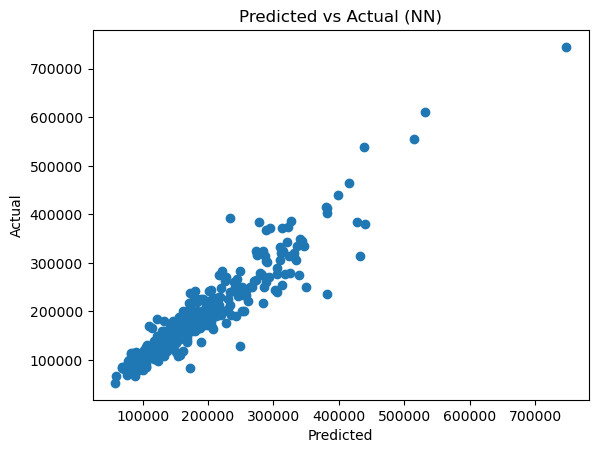

In [39]:
plt.scatter(nn_preds_, y_test)
plt.title('Predicted vs Actual (NN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
nn_preds = np.round(nn_preds, 2);
nn_preds

array([[121674.8 ],
       [179339.77],
       [184916.88],
       ...,
       [188830.06],
       [120056.87],
       [210032.8 ]], dtype=float32)

In [43]:
y_pred_sub_nn = pd.DataFrame(nn_preds, index =  sub_id, columns = ['SalePrice'])

In [44]:
y_pred_sub_nn

,SalePrice
Id,
1461,121674.796875
1462,179339.765625
1463,184916.875000
1464,185781.906250
1465,181638.093750
...,...
2915,79839.281250
2916,88967.773438
2917,188830.062500


In [45]:

y_pred_sub_nn.to_csv('Nlyford_sub_nn.csv' )